In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import random
import inflection
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML
from IPython.display         import Image
from scipy                   import stats as stats

from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost                 import XGBRegressor
import time


In [2]:
# function to show the missing values as a count and a percentage
def missing_data_summary(df):
    total_missing_values = df.isnull().sum()
    percentage_missing_values = (total_missing_values / len(df)) * 100
    summary_df = pd.DataFrame({'Total Missing': total_missing_values, 'Percentage Missing': percentage_missing_values})
    summary_df = summary_df.sort_values(by='Percentage Missing', ascending=False)
    return summary_df

In [3]:
# uploading using pandas read csv function
df_store = pd.read_csv('store.csv', low_memory=False)
df_train = pd.read_csv('train.csv', low_memory=False)
#the low_memory is set to false to load the full dataset into memory 

In [4]:
df_test = pd.read_csv('test.csv', low_memory=False)

In [5]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
missing_data_summary(df_store)

,Total Missing,Percentage Missing
Promo2SinceWeek,544,48.789238
Promo2SinceYear,544,48.789238
PromoInterval,544,48.789238
CompetitionOpenSinceMonth,354,31.748879
CompetitionOpenSinceYear,354,31.748879
CompetitionDistance,3,0.269058
Store,0,0.000000
StoreType,0,0.000000
Assortment,0,0.000000
Promo2,0,0.000000


In [7]:
missing_data_summary(df_train)

,Total Missing,Percentage Missing
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Sales          0 non-null      float64
 4   Customers      0 non-null      float64
 5   Open           41077 non-null  float64
 6   Promo          41088 non-null  int64  
 7   StateHoliday   41088 non-null  object 
 8   SchoolHoliday  41088 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 2.8+ MB


In [9]:
missing_data_summary(df_test)

,Total Missing,Percentage Missing
Sales,41088,100.000000
Customers,41088,100.000000
Open,11,0.026772
Store,0,0.000000
DayOfWeek,0,0.000000
Date,0,0.000000
Promo,0,0.000000
StateHoliday,0,0.000000
SchoolHoliday,0,0.000000


In [10]:
df_store['CompetitionDistance'].fillna(200000, inplace= True)

In [11]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

columns_for_imputation = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']


#apply MICE
imputer = IterativeImputer(max_iter=10, random_state=20)
df_store[columns_for_imputation] = imputer.fit_transform(df_store[columns_for_imputation])

# rounding off the imputations to integers
df_store[columns_for_imputation] = df_store[columns_for_imputation].round().astype(int)

df_store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6,2014,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4,2006,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,7,2009,0,NaN,NaN,NaN
1113,1114,a,c,870.0,7,2009,0,NaN,NaN,NaN


In [13]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int64  
 5   CompetitionOpenSinceYear   1115 non-null   int64  
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(3), int64(4), object(3)
memory usage: 87.2+ KB


In [14]:
df_store['PromoInterval'].fillna(0,inplace=True)
df_store['Promo2SinceWeek'].fillna(0, inplace=True)
df_store['Promo2SinceYear'].fillna(0, inplace=True)

In [15]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int64  
 5   CompetitionOpenSinceYear   1115 non-null   int64  
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 87.2+ KB


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [17]:
#assortment
df_store['Assortment'] = df_store['Assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df_train['StateHoliday'] = df_train['StateHoliday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 


In [18]:
# # One Hot Encoding
# state_holiday 
df_train = pd.get_dummies(df_train, prefix = ['StateHoliday'], columns = ['StateHoliday'])

# # Ordinal Encoding
# assortment
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df_store['Assortment'] = df_store['Assortment'].map( assortment_dict )

# encoding store_type
df_store = pd.get_dummies(df_store,prefix = ['StoreType'], columns = ['StoreType'])

# encoding PromoInterval
df_store =  pd.get_dummies(df_store, columns=['PromoInterval'], prefix=['PromoInterval'])

In [19]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Store                           1115 non-null   int64  
 1   Assortment                      1115 non-null   int64  
 2   CompetitionDistance             1115 non-null   float64
 3   CompetitionOpenSinceMonth       1115 non-null   int64  
 4   CompetitionOpenSinceYear        1115 non-null   int64  
 5   Promo2                          1115 non-null   int64  
 6   Promo2SinceWeek                 1115 non-null   float64
 7   Promo2SinceYear                 1115 non-null   float64
 8   StoreType_a                     1115 non-null   uint8  
 9   StoreType_b                     1115 non-null   uint8  
 10  StoreType_c                     1115 non-null   uint8  
 11  StoreType_d                     1115 non-null   uint8  
 12  PromoInterval_0                 11

In [20]:
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].astype( int )
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].astype( int )
df_store['Promo2SinceWeek'] = df_store['Promo2SinceWeek'].astype( int )
df_store['Promo2SinceYear'] = df_store['Promo2SinceYear'].astype( int )

In [21]:
df_train = df_train[(df_train['Open'] != 0) & (df_train['Sales'] > 0)]

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Store                        844338 non-null  int64 
 1   DayOfWeek                    844338 non-null  int64 
 2   Date                         844338 non-null  object
 3   Sales                        844338 non-null  int64 
 4   Customers                    844338 non-null  int64 
 5   Open                         844338 non-null  int64 
 6   Promo                        844338 non-null  int64 
 7   SchoolHoliday                844338 non-null  int64 
 8   StateHoliday_christmas       844338 non-null  uint8 
 9   StateHoliday_easter_holiday  844338 non-null  uint8 
 10  StateHoliday_public_holiday  844338 non-null  uint8 
 11  StateHoliday_regular_day     844338 non-null  uint8 
dtypes: int64(7), object(1), uint8(4)
memory usage: 61.2+ MB


In [23]:
#merging datasets
df = pd.merge(df_train, df_store, how = 'left', on = 'Store')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Store                           844338 non-null  int64  
 1   DayOfWeek                       844338 non-null  int64  
 2   Date                            844338 non-null  object 
 3   Sales                           844338 non-null  int64  
 4   Customers                       844338 non-null  int64  
 5   Open                            844338 non-null  int64  
 6   Promo                           844338 non-null  int64  
 7   SchoolHoliday                   844338 non-null  int64  
 8   StateHoliday_christmas          844338 non-null  uint8  
 9   StateHoliday_easter_holiday     844338 non-null  uint8  
 10  StateHoliday_public_holiday     844338 non-null  uint8  
 11  StateHoliday_regular_day        844338 non-null  uint8  
 12  Assortment      

In [25]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844338 entries, 2013-01-01 to 2015-07-31
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Store                           844338 non-null  int64  
 1   DayOfWeek                       844338 non-null  int64  
 2   Sales                           844338 non-null  int64  
 3   Customers                       844338 non-null  int64  
 4   Open                            844338 non-null  int64  
 5   Promo                           844338 non-null  int64  
 6   SchoolHoliday                   844338 non-null  int64  
 7   StateHoliday_christmas          844338 non-null  uint8  
 8   StateHoliday_easter_holiday     844338 non-null  uint8  
 9   StateHoliday_public_holiday     844338 non-null  uint8  
 10  StateHoliday_regular_day        844338 non-null  uint8  
 11  Assortment                      844338 non-null  int64  
 12  

In [27]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844338 entries, 2013-01-01 to 2015-07-31
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Store                           844338 non-null  int64  
 1   DayOfWeek                       844338 non-null  int64  
 2   Sales                           844338 non-null  int64  
 3   Customers                       844338 non-null  int64  
 4   Open                            844338 non-null  int64  
 5   Promo                           844338 non-null  int64  
 6   SchoolHoliday                   844338 non-null  int64  
 7   StateHoliday_christmas          844338 non-null  uint8  
 8   StateHoliday_easter_holiday     844338 non-null  uint8  
 9   StateHoliday_public_holiday     844338 non-null  uint8  
 10  StateHoliday_regular_day        844338 non-null  uint8  
 11  Assortment                      844338 non-null  int64  
 12  

In [29]:
df = df.drop(['Open','Customers'], axis=1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844338 entries, 2013-01-01 to 2015-07-31
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Store                           844338 non-null  int64  
 1   DayOfWeek                       844338 non-null  int64  
 2   Sales                           844338 non-null  int64  
 3   Promo                           844338 non-null  int64  
 4   SchoolHoliday                   844338 non-null  int64  
 5   StateHoliday_christmas          844338 non-null  uint8  
 6   StateHoliday_easter_holiday     844338 non-null  uint8  
 7   StateHoliday_public_holiday     844338 non-null  uint8  
 8   StateHoliday_regular_day        844338 non-null  uint8  
 9   Assortment                      844338 non-null  int64  
 10  CompetitionDistance             844338 non-null  float64
 11  CompetitionOpenSinceMonth       844338 non-null  int64  
 12  

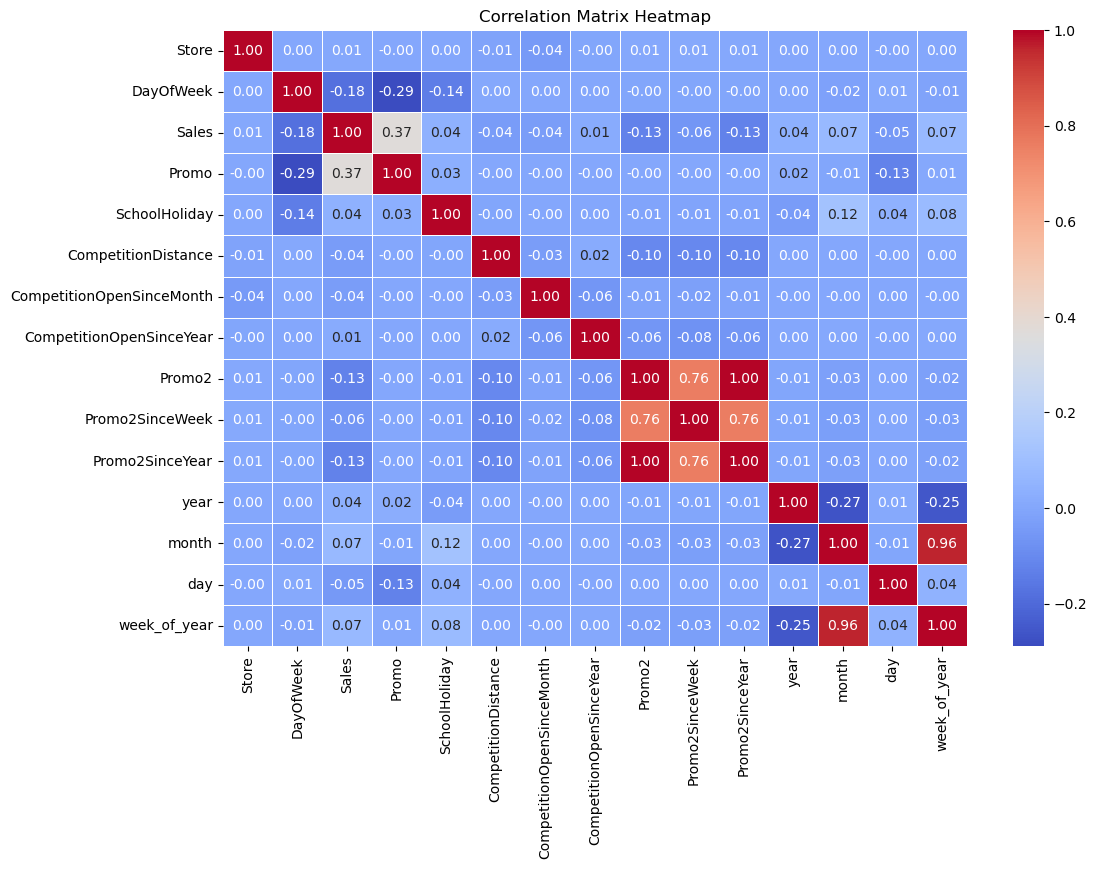

In [25]:
num_attributes = df.select_dtypes( include = ['int32', 'int64', 'float64'] )
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True,fmt = '.2f', cmap='coolwarm', linewidths=0.5)
# Change the display format .descibe doesn't use scientific notation.
#pd.set_option('display.float_format', '{:.2f}'.format)
plt.title('Correlation Matrix Heatmap')
plt.show()


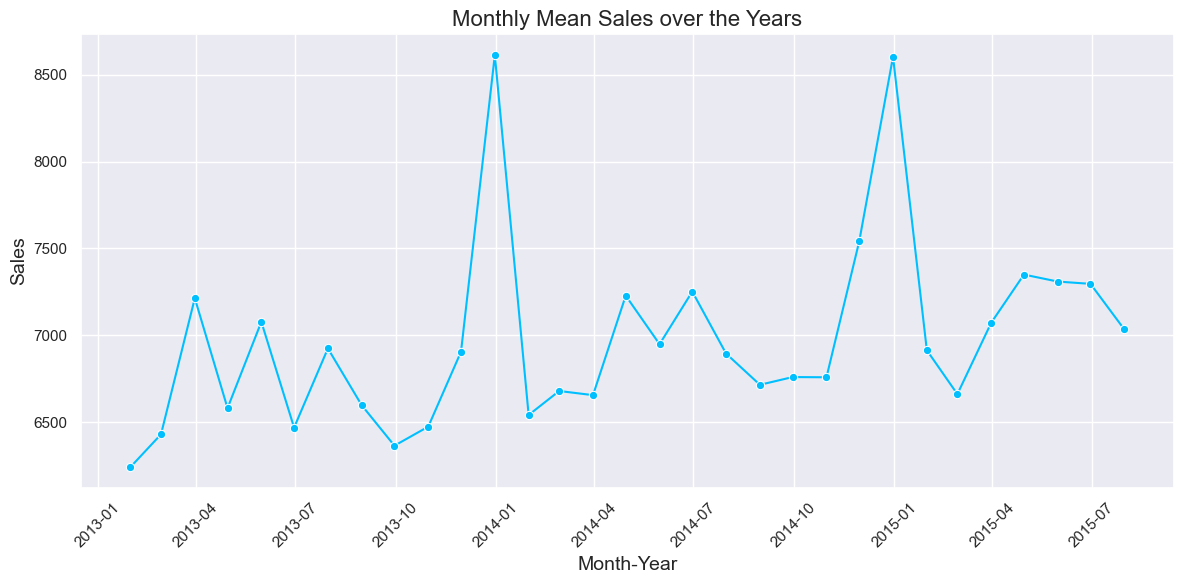

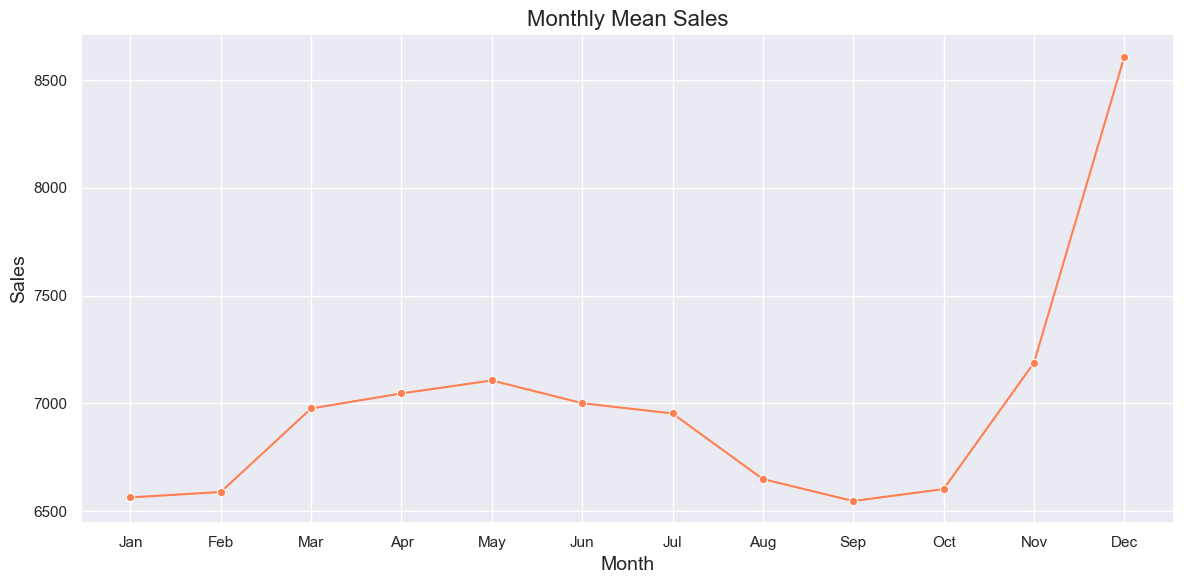

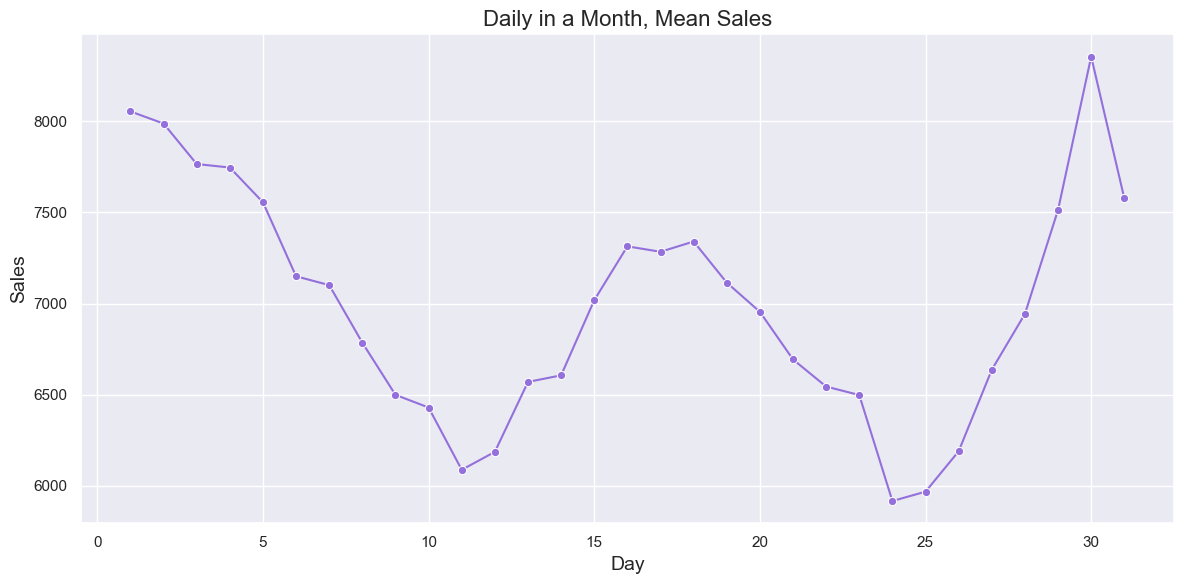

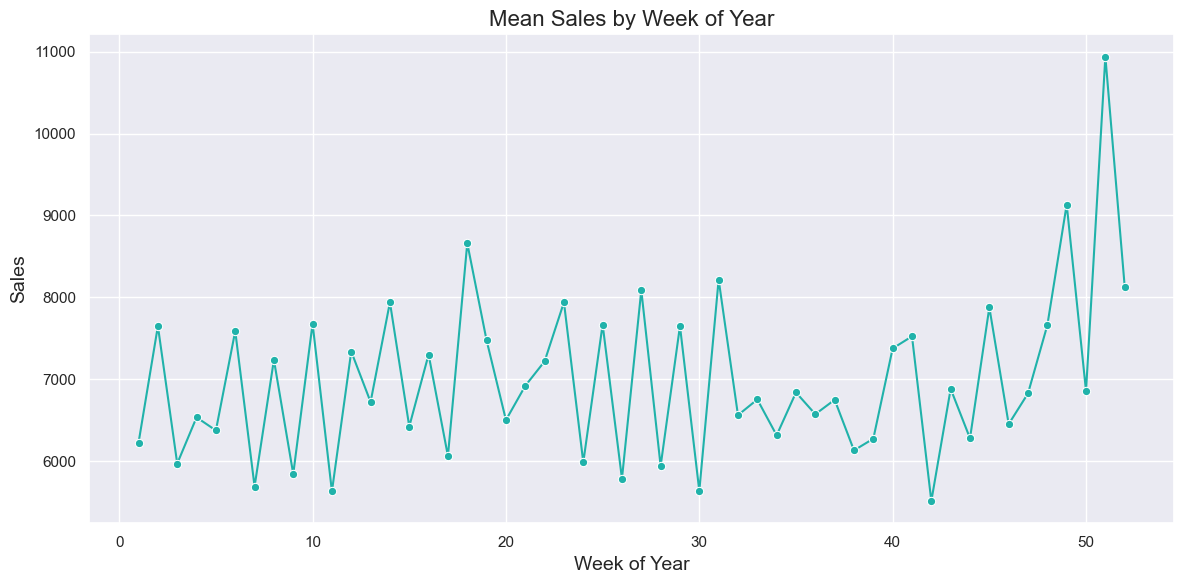

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# CREATING A LINE CHART FOR MONTHLY MEAN SALES
monthly_mean_sales = df['Sales'].resample('M').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_mean_sales.index, y=monthly_mean_sales.values, marker='o', linestyle='-', color='deepskyblue')
plt.title("Monthly Mean Sales over the Years", fontsize=16)
plt.xlabel("Month-Year", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# CREATING A LINE CHART FOR MONTHLY SALES MEAN
group_sales_M = df.groupby(df.index.month)['Sales'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=group_sales_M.index, y=group_sales_M.values, marker='o', linestyle='-', color='coral')
plt.title("Monthly Mean Sales", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

# CREATING A LINE CHART FOR DAILY MEAN SALES
group_sales_D = df.groupby(df.index.day)['Sales'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=group_sales_D.index, y=group_sales_D.values, marker='o', linestyle='-', color='mediumpurple')
plt.title("Daily in a Month, Mean Sales", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.tight_layout()
plt.show()

# CREATING A LINE CHART FOR MEAN SALES BY WEEK OF YEAR
group_sales_wkyr = df.groupby(df.index.weekofyear)['Sales'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=group_sales_wkyr.index, y=group_sales_wkyr.values, marker='o', linestyle='-', color='lightseagreen')
plt.title("Mean Sales by Week of Year", fontsize=16)
plt.xlabel("Week of Year", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.tight_layout()
plt.show()

# CREATING A BAR CHART FOR MEAN


<Axes: xlabel='Sales', ylabel='Density'>

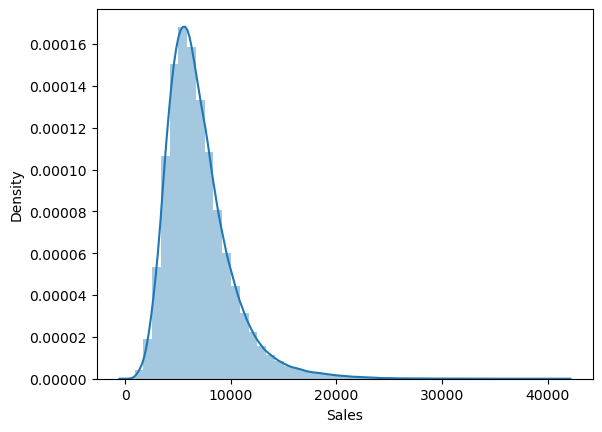

In [28]:
sns.distplot( df['Sales'] )

In [31]:
df['Sales'] = np.log1p( df['Sales'] )

<Axes: xlabel='Sales', ylabel='Density'>

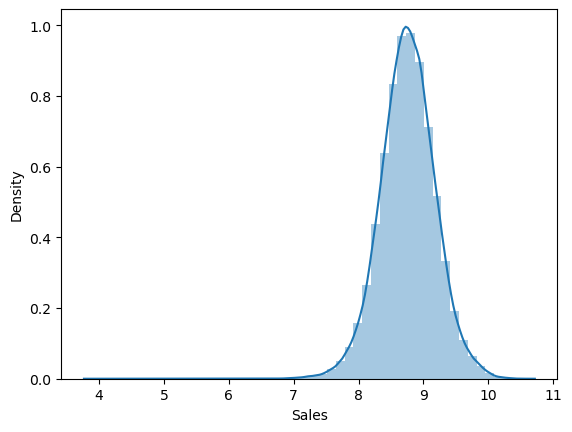

In [30]:
sns.distplot(df['Sales'])

<Axes: xlabel='CompetitionDistance', ylabel='Density'>

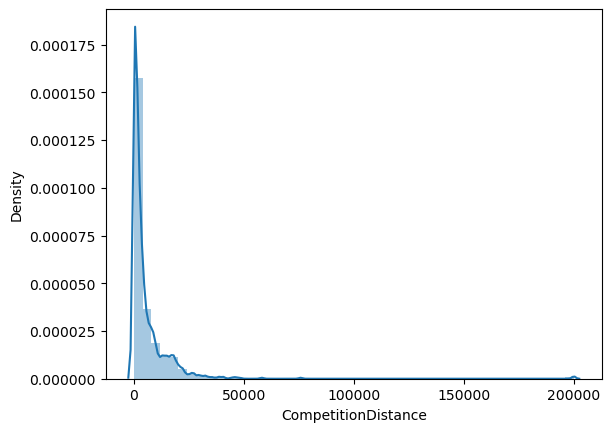

In [31]:
sns.distplot(df['CompetitionDistance'])

In [32]:
from scipy.stats import boxcox
import numpy as np

# Assuming df is your DataFrame containing the Rossman Sales data

# Drop rows with missing values in 'CompetitionDistance' if needed
# df = df.dropna(subset=['CompetitionDistance'])

# Apply Box-Cox transformation to 'CompetitionDistance' variable
df['CompetitionDistance'],lambda_value = boxcox(df['CompetitionDistance'] + 1)  # Adding 1 to avoid zero values




<Axes: xlabel='CompetitionDistance', ylabel='Density'>

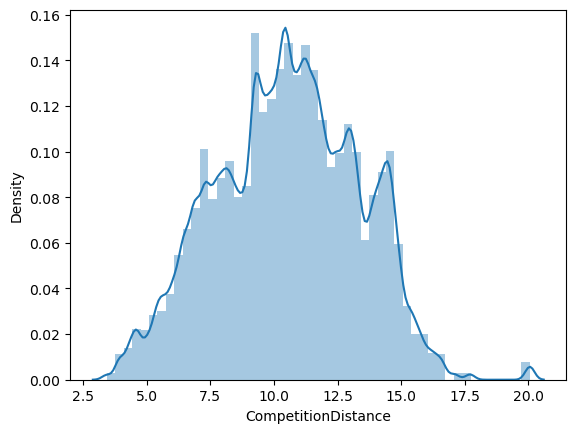

In [33]:
sns.distplot(df['CompetitionDistance'])

<Axes: xlabel='Promo', ylabel='Sales'>

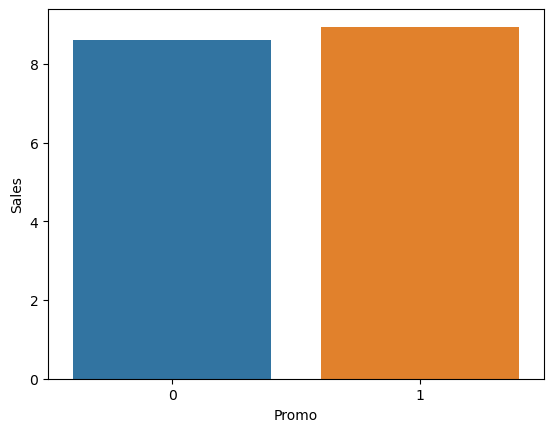

In [78]:
sns.barplot(x=df['Promo'], y=df['Sales'])

In [33]:
df = df.drop(['Promo2SinceWeek','Promo2SinceYear','week_of_year'], axis=1)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844338 entries, 2013-01-01 to 2015-07-31
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Store                           844338 non-null  int64  
 1   DayOfWeek                       844338 non-null  int64  
 2   Sales                           844338 non-null  float64
 3   Promo                           844338 non-null  int64  
 4   SchoolHoliday                   844338 non-null  int64  
 5   StateHoliday_christmas          844338 non-null  uint8  
 6   StateHoliday_easter_holiday     844338 non-null  uint8  
 7   StateHoliday_public_holiday     844338 non-null  uint8  
 8   StateHoliday_regular_day        844338 non-null  uint8  
 9   Assortment                      844338 non-null  int64  
 10  CompetitionDistance             844338 non-null  float64
 11  CompetitionOpenSinceMonth       844338 non-null  int64  
 12  

In [82]:
### split Data
# training dataset
train = df[:'2015-06-18']
valid = df['2015-06-19':]

In [83]:
train.tail()

,Store,DayOfWeek,Sales,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter_holiday,StateHoliday_public_holiday,StateHoliday_regular_day,Assortment,...,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",year,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-18,744,4,8.964951,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,2015,6,18
2015-06-18,745,4,8.928110,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,2015,6,18
2015-06-18,746,4,8.940367,1,0,0,0,0,1,3,...,0,0,1,0,0,0,1,2015,6,18
2015-06-18,747,4,9.003685,1,0,0,0,0,1,3,...,0,1,0,1,0,0,0,2015,6,18
2015-06-18,741,4,9.015906,1,0,0,0,0,1,3,...,0,0,1,1,0,0,0,2015,6,18


In [84]:
valid.head()

,Store,DayOfWeek,Sales,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter_holiday,StateHoliday_public_holiday,StateHoliday_regular_day,Assortment,...,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",year,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-19,373,5,8.624252,1,0,0,0,0,1,3,...,0,0,1,0,0,1,0,2015,6,19
2015-06-19,369,5,8.791334,1,0,0,0,0,1,3,...,0,0,1,1,0,0,0,2015,6,19
2015-06-19,370,5,9.029538,1,0,0,0,0,1,1,...,0,0,1,0,0,1,0,2015,6,19
2015-06-19,371,5,8.955577,1,0,0,0,0,1,3,...,0,0,1,0,1,0,0,2015,6,19
2015-06-19,372,5,9.318028,1,0,0,0,0,1,3,...,0,0,1,0,0,1,0,2015,6,19


In [85]:
valid.tail()

,Store,DayOfWeek,Sales,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter_holiday,StateHoliday_public_holiday,StateHoliday_regular_day,Assortment,...,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",year,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,745,5,9.031692,1,1,0,0,0,1,1,...,0,0,0,0,0,1,0,2015,7,31
2015-07-31,746,5,9.114160,1,1,0,0,0,1,3,...,0,0,1,0,0,0,1,2015,7,31
2015-07-31,747,5,9.278840,1,1,0,0,0,1,3,...,0,1,0,1,0,0,0,2015,7,31
2015-07-31,741,5,9.328479,1,1,0,0,0,1,3,...,0,0,1,1,0,0,0,2015,7,31
2015-07-31,1,5,8.568646,1,1,0,0,0,1,1,...,0,1,0,1,0,0,0,2015,7,31


In [86]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error


X = train.drop(['Sales'], axis=1)
y = train['Sales']


# Implementing Time Series Split with 3 splits
tscv = TimeSeriesSplit(n_splits=3)

# Defining the parameter grid for randomized search
param_grid = {
    'n_estimators': list(range(100, 700, 100)),  # Number of boosting rounds (trees).
    'max_depth': list(range(1, 10, 3)),  # Maximum depth of each tree.
    'learning_rate': [0.1, 0.01, 0.001],  # The learning rate.
    'reg_alpha': [0.0, 0.1, 0.01, 0.001],  # L1 regularization term.
    'reg_lambda': [0.0, 0.1, 0.01, 0.001],  # L2 regularization term.
}

# Creating XGBoost Model
model = XGBRegressor(random_state=20, n_jobs = -1)

# Creating RandomizedSearch CV grid
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10,
                                   scoring='neg_mean_absolute_error', random_state=20, cv=tscv, n_jobs=-1)

# Create a list to store the RMSE scores for each fold
rmse_scores = []

# Measuring run time for Cross Validation
start_time = time.time()

# Performing RandomizedSearchCV using Time Series split to separate training and validation sets.
random_search.fit(X, y)

# Storing the best model from randomized search CV
best_model = random_search.best_estimator_

# Print the run time for randomized search CV
elapsed_time = time.time() - start_time
print(f"Randomized Search took {elapsed_time:.2f} seconds.")
print("\n")

# Print the best hyperparameters from the randomized search
print("Best Hyperparameters:", random_search.best_params_)

# Printing the performance of the best model on each TimeSeriesSplit to measure performance across folds
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    y_test = np.expm1(y_test)
    
    predictions = best_model.predict(X_test)
    predictions = np.expm1(predictions)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test,predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    #original_rmse = np.expm1(rmse)
    rmse_scores.append(rmse)

    print(f"RMSE for this fold: {rmse}")
    print(f"MAE for this fold: {mae}")
    print(f"MAPE for this fold: {mape}")
    print("\n")
 

    """y_test_original = np.expm1(validation_y)  # Inverse of np.log1p
predictions_original = np.expm1(validation_predictions)  # Inverse of np.log1p

# Now, calculate RMSE in the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, predictions_original))

print("RMSE in original scale:", rmse_original)"""

Randomized Search took 55.40 seconds.


Best Hyperparameters: {'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.1}
RMSE for this fold: 783.8451722399269
MAE for this fold: 522.5773278805857
MAPE for this fold: 0.0790311517139918


RMSE for this fold: 737.8145726073258
MAE for this fold: 495.67395258460317
MAPE for this fold: 0.07440243991900326


RMSE for this fold: 757.3544605178033
MAE for this fold: 533.6064981955474
MAPE for this fold: 0.07721373517547749




In [87]:
# This is to test on our Predictons Dataset

X_evaluation = valid.drop(['Sales'], axis = 1)
y_evaluation = valid['Sales'] 
y_predictions = best_model.predict(X_evaluation)

y_evaluation = np.expm1(y_evaluation)
y_predictions = np.expm1(y_predictions)
# Evaluate the models performance on the test set
mse = mean_squared_error(y_evaluation, y_predictions)
rmse = np.sqrt(mse)
#original_rmse = np.exp(rmse)

print(f"RMSE for test: {rmse}")
print(f"MAE for test: {mae}")
print(f"MAPE for test: {mape}")

RMSE for test: 1010.8943306973766
MAE for test: 533.6064981955474
MAPE for test: 0.07721373517547749


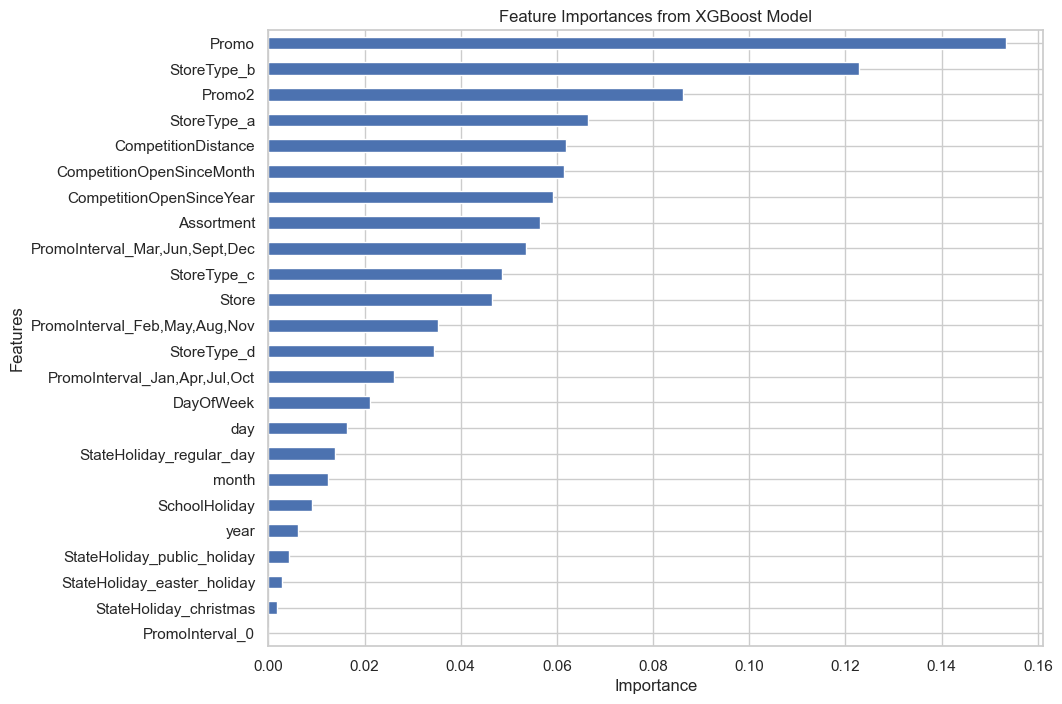

In [120]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'X' has column names that represent the features
feature_names = X.columns

# Extract feature importances from the model
importances = best_model.feature_importances_

# Create a pandas Series for easier plotting, using the feature names as the index
importances_series = pd.Series(importances, index=feature_names)

# Sort the importances
sorted_importances = importances_series.sort_values()

# Create a bar chart
plt.figure(figsize=(10, 8))
sorted_importances.plot(kind='barh')
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Sales          0 non-null      float64
 4   Customers      0 non-null      float64
 5   Open           41077 non-null  float64
 6   Promo          41088 non-null  int64  
 7   StateHoliday   41088 non-null  object 
 8   SchoolHoliday  41088 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 2.8+ MB


In [99]:
df_test_copy = pd.merge (df_test, df_store, how = "left", on = 'Store')

In [101]:
df_test_copy = df_test_copy[(df_test_copy['Open'] != 0)]

In [102]:
df_test_copy

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Assortment,...,Promo2SinceWeek,Promo2SinceYear,StoreType_a,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,4,17/09/2015,NaN,NaN,1.0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,3,4,17/09/2015,NaN,NaN,1.0,1,0,0,1,...,14,2011,1,0,0,0,0,0,1,0
2,7,4,17/09/2015,NaN,NaN,1.0,1,0,0,3,...,0,0,1,0,0,0,1,0,0,0
3,8,4,17/09/2015,NaN,NaN,1.0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,9,4,17/09/2015,NaN,NaN,1.0,1,0,0,3,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,01/08/2015,NaN,NaN,1.0,0,0,0,1,...,31,2013,1,0,0,0,0,0,1,0
41084,1112,6,01/08/2015,NaN,NaN,1.0,0,0,0,3,...,0,0,0,0,1,0,1,0,0,0
41085,1113,6,01/08/2015,NaN,NaN,1.0,0,0,0,3,...,0,0,1,0,0,0,1,0,0,0
41086,1114,6,01/08/2015,NaN,NaN,1.0,0,0,0,3,...,0,0,1,0,0,0,1,0,0,0


In [103]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 41087
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Store                           35104 non-null  int64  
 1   DayOfWeek                       35104 non-null  int64  
 2   Date                            35104 non-null  object 
 3   Sales                           0 non-null      float64
 4   Customers                       0 non-null      float64
 5   Open                            35093 non-null  float64
 6   Promo                           35104 non-null  int64  
 7   StateHoliday                    35104 non-null  object 
 8   SchoolHoliday                   35104 non-null  int64  
 9   Assortment                      35104 non-null  int64  
 10  CompetitionDistance             35104 non-null  float64
 11  CompetitionOpenSinceMonth       35104 non-null  int64  
 12  CompetitionOpenSinceYear        

In [104]:
df_test_copy = df_test_copy.drop(['Customers','Open','Promo2SinceWeek','Promo2SinceYear'], axis=1)

In [105]:
df_test_copy['Date'] = pd.to_datetime(df_test_copy['Date'], format = "%d/%m/%Y")
df_test_copy.set_index('Date', inplace=True)
df_test_copy.sort_index(ascending=True)

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
Date,,,,,,,,,,,,,,,,,,,
2015-08-01,1115,6,NaN,0,0,1,3,5350.0,7,2009,1,0,0,0,1,0,0,0,1
2015-08-01,378,6,NaN,0,0,0,3,2140.0,8,2012,0,1,0,0,0,1,0,0,0
2015-08-01,377,6,NaN,0,0,0,3,100.0,6,2010,1,1,0,0,0,0,1,0,0
2015-08-01,373,6,NaN,0,0,0,3,11120.0,7,2009,1,0,0,0,1,0,0,1,0
2015-08-01,372,6,NaN,0,0,0,3,4880.0,8,2010,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-17,731,4,NaN,1,0,0,1,15270.0,7,2009,1,1,0,0,0,0,0,1,0
2015-09-17,729,4,NaN,1,0,0,3,8980.0,6,2011,0,0,0,1,0,1,0,0,0
2015-09-17,728,4,NaN,1,0,0,1,13990.0,7,2009,1,0,0,0,1,0,0,1,0


In [106]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Store                           1115 non-null   int64  
 1   Assortment                      1115 non-null   int64  
 2   CompetitionDistance             1115 non-null   float64
 3   CompetitionOpenSinceMonth       1115 non-null   int64  
 4   CompetitionOpenSinceYear        1115 non-null   int64  
 5   Promo2                          1115 non-null   int64  
 6   Promo2SinceWeek                 1115 non-null   int64  
 7   Promo2SinceYear                 1115 non-null   int64  
 8   StoreType_a                     1115 non-null   uint8  
 9   StoreType_b                     1115 non-null   uint8  
 10  StoreType_c                     1115 non-null   uint8  
 11  StoreType_d                     1115 non-null   uint8  
 12  PromoInterval_0                 11

In [44]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-09-17 to 2015-08-01
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Store                           41088 non-null  int64  
 1   DayOfWeek                       41088 non-null  int64  
 2   Sales                           0 non-null      float64
 3   Promo                           41088 non-null  int64  
 4   StateHoliday                    41088 non-null  object 
 5   SchoolHoliday                   41088 non-null  int64  
 6   Assortment                      41088 non-null  int64  
 7   CompetitionDistance             41088 non-null  float64
 8   CompetitionOpenSinceMonth       41088 non-null  int64  
 9   CompetitionOpenSinceYear        41088 non-null  int64  
 10  Promo2                          41088 non-null  int64  
 11  StoreType_a                     41088 non-null  uint8  
 12  StoreType_b    

In [107]:
state_holiday_counts = df_test_copy['StateHoliday'].value_counts()

# Display the unique values and their counts
print(state_holiday_counts)


0    35078
a       26
Name: StateHoliday, dtype: int64


In [108]:
#assortment
#df_test_copy['Assortment'] = df_test_copy['Assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df_test_copy['StateHoliday'] = df_test_copy['StateHoliday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 


In [109]:
state_holiday_counts = df_test_copy['StateHoliday'].value_counts()

# Display the unique values and their counts
print(state_holiday_counts)

regular_day       35078
public_holiday       26
Name: StateHoliday, dtype: int64


In [110]:
# # One Hot Encoding
# state_holiday 
df_test_copy = pd.get_dummies(df_test_copy, prefix = ['StateHoliday'], columns = ['StateHoliday'])

# # Ordinal Encoding
# assortment
#assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
#df_test_copy['Assortment'] = df_test_copy['Assortment'].map( assortment_dict )

# encoding store_type
#df_test_copy = pd.get_dummies(df_test_copy,prefix = ['StoreType'], columns = ['StoreType'])

# encoding PromoInterval
#df_test_copy =  pd.get_dummies(df_test_copy, columns=['PromoInterval'], prefix=['PromoInterval'])

In [111]:
df_test_copy['year'] = df_test_copy.index.year
df_test_copy['month'] = df_test_copy.index.month
df_test_copy['day'] = df_test_copy.index.day


In [112]:
# Create two new columns 'NewColumn1' and 'NewColumn2' filled with 0s
df_test_copy['StateHoliday_christmas'] = 0
df_test_copy['StateHoliday_easter_holiday'] = 0

# Ensure the new columns are of integer data type
df_test_copy['StateHoliday_christmas'] = df_test_copy['StateHoliday_christmas'].astype(int)
df_test_copy['StateHoliday_easter_holiday'] = df_test_copy['StateHoliday_easter_holiday'].astype(int)


In [113]:
df_test_copy = df_test_copy[X_train.columns]

In [54]:
df_test_copy

,Store,DayOfWeek,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter_holiday,StateHoliday_public_holiday,StateHoliday_regular_day,Assortment,CompetitionDistance,...,StoreType_b,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",year,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,1,0,0,0,0,1,1,1270.0,...,0,1,0,1,0,0,0,2015,9,17
2015-09-17,3,4,1,0,0,0,0,1,1,14130.0,...,0,0,0,0,0,1,0,2015,9,17
2015-09-17,7,4,1,0,0,0,0,1,3,24000.0,...,0,0,0,1,0,0,0,2015,9,17
2015-09-17,8,4,1,0,0,0,0,1,1,7520.0,...,0,0,0,1,0,0,0,2015,9,17
2015-09-17,9,4,1,0,0,0,0,1,3,2030.0,...,0,0,0,1,0,0,0,2015,9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,1111,6,0,0,0,0,0,1,1,1900.0,...,0,0,0,0,0,1,0,2015,8,1
2015-08-01,1112,6,0,0,0,0,0,1,3,1880.0,...,0,1,0,1,0,0,0,2015,8,1
2015-08-01,1113,6,0,0,0,0,0,1,3,9260.0,...,0,0,0,1,0,0,0,2015,8,1


In [114]:
# Assuming df_test_copy is your new dataframe without 'Sales' values
# and it's already preprocessed to match the training data format
#df_test_copy_without_sales = df_test_copy.drop('Sales', axis=1)
# Predict sales for df_test_copy
predicted_sales = best_model.predict(df_test_copy)

# If you've applied a log transformation (np.log1p) to the target during training,
# reverse the transformation on the predictions:
# predicted_sales = np.expm1(predicted_sales)

# Store the predicted sales values in df_test_copy
df_test_copy['Predicted_Sales'] = predicted_sales

# Now df_test_copy contains a new column 'Predicted_Sales' with the sales predictions


In [115]:
df_test_copy

,Store,DayOfWeek,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter_holiday,StateHoliday_public_holiday,StateHoliday_regular_day,Assortment,CompetitionDistance,...,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",year,month,day,Predicted_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,1,0,0,0,0,1,1,1270.0,...,1,0,1,0,0,0,2015,9,17,8.674131
2015-09-17,3,4,1,0,0,0,0,1,1,14130.0,...,0,0,0,0,1,0,2015,9,17,8.613490
2015-09-17,7,4,1,0,0,0,0,1,3,24000.0,...,0,0,1,0,0,0,2015,9,17,8.524991
2015-09-17,8,4,1,0,0,0,0,1,1,7520.0,...,0,0,1,0,0,0,2015,9,17,8.704112
2015-09-17,9,4,1,0,0,0,0,1,3,2030.0,...,0,0,1,0,0,0,2015,9,17,8.710855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,1111,6,0,0,0,0,0,1,1,1900.0,...,0,0,0,0,1,0,2015,8,1,7.930107
2015-08-01,1112,6,0,0,0,0,0,1,3,1880.0,...,1,0,1,0,0,0,2015,8,1,8.695811
2015-08-01,1113,6,0,0,0,0,0,1,3,9260.0,...,0,0,1,0,0,0,2015,8,1,8.494529


In [116]:
df_test_copy['Predicted_Sales'] = np.expm1(df_test_copy['Predicted_Sales'])

In [117]:
df_test_copy

,Store,DayOfWeek,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter_holiday,StateHoliday_public_holiday,StateHoliday_regular_day,Assortment,CompetitionDistance,...,StoreType_c,StoreType_d,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",year,month,day,Predicted_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,1,0,0,0,0,1,1,1270.0,...,1,0,1,0,0,0,2015,9,17,5848.616699
2015-09-17,3,4,1,0,0,0,0,1,1,14130.0,...,0,0,0,0,1,0,2015,9,17,5504.429688
2015-09-17,7,4,1,0,0,0,0,1,3,24000.0,...,0,0,1,0,0,0,2015,9,17,5038.141602
2015-09-17,8,4,1,0,0,0,0,1,1,7520.0,...,0,0,1,0,0,0,2015,9,17,6026.647461
2015-09-17,9,4,1,0,0,0,0,1,3,2030.0,...,0,0,1,0,0,0,2015,9,17,6067.425781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,1111,6,0,0,0,0,0,1,1,1900.0,...,0,0,0,0,1,0,2015,8,1,2778.724609
2015-08-01,1112,6,0,0,0,0,0,1,3,1880.0,...,1,0,1,0,0,0,2015,8,1,5976.820312
2015-08-01,1113,6,0,0,0,0,0,1,3,9260.0,...,0,0,1,0,0,0,2015,8,1,4886.952637


In [69]:
daily_sales = df_test_copy['Predicted_Sales'].resample('D').sum()

In [70]:
daily_sales

Date
2015-08-01    3954973.500
2015-08-02    3188286.250
2015-08-03    6686611.000
2015-08-04    5046562.500
2015-08-05    4882445.000
2015-08-06    5048953.000
2015-08-07    5266126.500
2015-08-08    3072634.500
2015-08-09    2817014.750
2015-08-10    4357794.500
2015-08-11    3985350.500
2015-08-12    3902040.750
2015-08-13    4162903.000
2015-08-14    4640046.500
2015-08-15    3025157.000
2015-08-16    2788881.250
2015-08-17    6834423.500
2015-08-18    5293954.500
2015-08-19    4823086.500
2015-08-20    4928415.000
2015-08-21    5101022.500
2015-08-22    3028137.500
2015-08-23    2858964.750
2015-08-24    4483213.500
2015-08-25    3924433.750
2015-08-26    3925995.500
2015-08-27    3911105.500
2015-08-28    4537316.500
2015-08-29    3076219.250
2015-08-30    2948886.000
2015-08-31    7720901.500
2015-09-01    5527546.000
2015-09-02    5710077.500
2015-09-03    5241482.500
2015-09-04    5311706.000
2015-09-05    2814497.500
2015-09-06    2028282.375
2015-09-07    4016521.750
2015-09

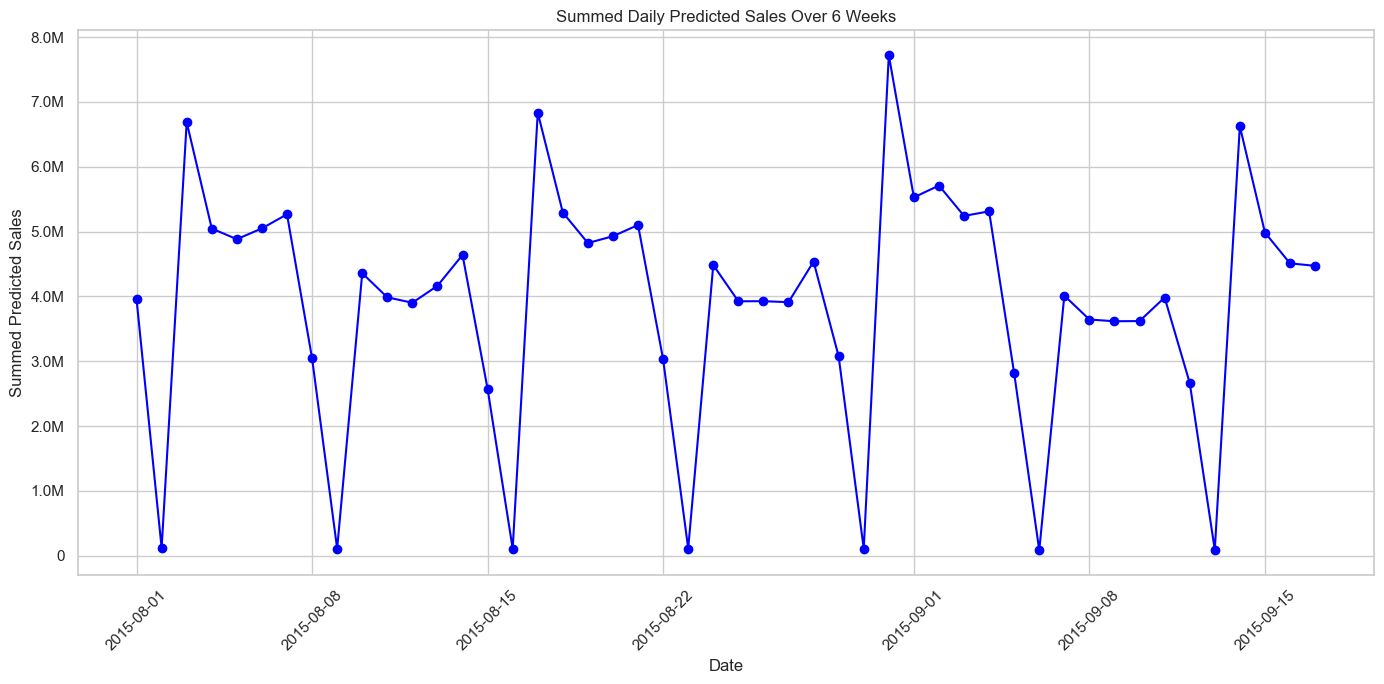

In [118]:
# Sum Predicted_Sales by day
import matplotlib.ticker as ticker
daily_sales = df_test_copy['Predicted_Sales'].resample('D').sum()

# Select a 6-week period for plotting
# For demonstration, let's assume you want to start from the first date in your DataFrame


# Filter the daily_sales for the 6-week period
six_weeks_sales = daily_sales

plt.figure(figsize=(14, 7))

plt.plot(six_weeks_sales.index, six_weeks_sales.values, marker='o', linestyle='-', color='blue')
plt.title('Summed Daily Predicted Sales Over 6 Weeks')
plt.xlabel('Date')
plt.ylabel('Summed Predicted Sales')
plt.xticks(rotation=45)
plt.grid(True)

# Format y-axis to show sales numbers with 'K' for thousands
# If your numbers are indeed large and you want them to be readable
def format_func(value, tick_number):
    # This function converts large numbers into a human-readable format
    if value >= 1e6:  # Millions
        return f'{value/1e6:.1f}M'
    elif value >= 1e3:  # Thousands
        return f'{value/1e3:.0f}K'
    else:
        return int(value)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout()
plt.show()



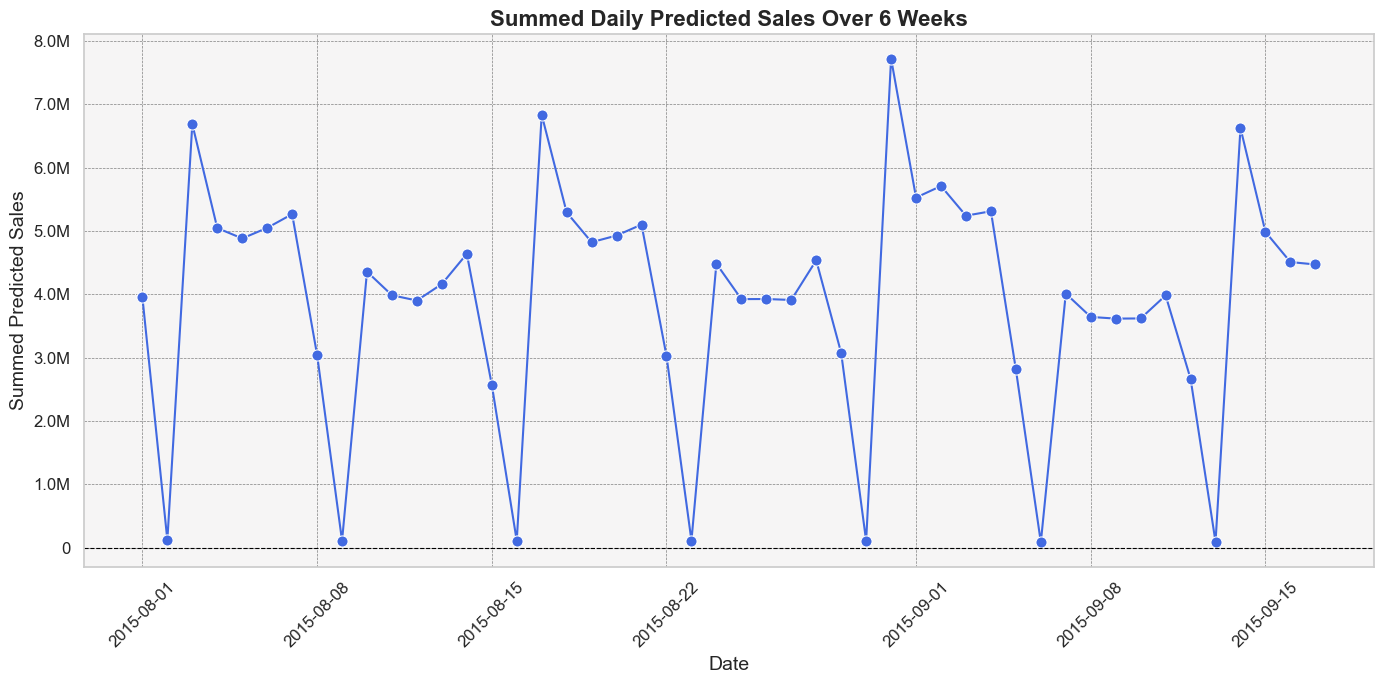

In [119]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Set the Seaborn theme for better aesthetics
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(14, 7))
# Use Seaborn's lineplot for automatic date formatting and a more attractive line style
sns.lineplot(x=six_weeks_sales.index, y=six_weeks_sales.values, marker='o', linestyle='-', color='royalblue', markersize=8)

plt.title('Summed Daily Predicted Sales Over 6 Weeks', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Summed Predicted Sales', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Improve grid style
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')

# Format y-axis to show sales numbers with 'K' for thousands
def format_func(value, tick_number):
    if value >= 1e6:  # Millions
        return f'{value/1e6:.1f}M'
    elif value >= 1e3:  # Thousands
        return f'{value/1e3:.0f}K'
    else:
        return int(value)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# Adding a soft background color
plt.gca().set_facecolor('#f6f5f5')

# Highlighting the zero line for reference
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()
